# <center>Assignment 4 [Final]

In [1]:
Your_name = "Ishan Pandey"
Your_emailid = "ishanpandeycse@gmail.com"

### **NOTE: Open this notebook in kaggle and import Artificial Lunar Landscape Dataset.** 

## > If you run this notebook as it is, you will get the val_iou_score of around 0.20 (remember to use GPU for training the model)

## > Your goal is to increase the val_iou_score as much as you can for this project using any method. The evaluation of this assignment will be based on your acquired val_iou_score. One point for each increasing 0.01 val_iou_score. 

> For example - if val_iou_score = 0.41, your points will be 41/100. 

## > Please check your notebook before submission, try to avoid any error.

### Some tips to increase the performance
* Increase the number of epochs
* Increase the number of layers in your model
* Using SOTA high performance networks with transfer learning
* Using callbacks and carefully observing your model performance

You are free to use other techniques too. 

# GUIDELINES ABOUT MAKING CHANGES TO THIS NOTEBOOK

For every change you make to this notebook, only those supported by the following would be considered for evaluation:

1. A descriptive comment explaining the change, e.g., if you are adding an extra conv2d layer, write about all the aspects of the conv2d layer you are adding. The comment should be placed at the point where the layer will be added. 

2. Changes brought to the system because of changes you introduced, e.g., if you changed layers - added, deleted, etc., you MUST show model properties before and after the changes were made.

3. Data preprocessing changes - if you use new data preprocessing techniques that are not a part of this notebook, you MUST explain their inner workings using 2-3 MARKDOWN cells, and ONLY AFTER THAT,  proceed to use that technique. Without this explanation, your technique will not be considered for evaluation.

4. ALL improvements MUST BE REPORTED VIA PLOTS OR TABLES OR BOTH, e.g., if increasing epochs from 30 to 50 improved your results, but decreasing learning_rate from 0.0001 to 0.00005 also improved your results, then these gains FIRST HAVE TO BE REPORTED SEPARATELY VIA PLOTS, THEN AGAIN TOGETHER VIA TABLES. 

  One plot can show iou values increasing from epoch 30 to epoch 50. Another plot can show iou values improving at varying learning rates. Finally tables can be used to show iou values for different learning rates, table 1 for lr_1 shows iou for epochs 30 through 50, table 2 for lr_2 shows iou for epochs 30 through 50, and so on and so forth - ALL YOUR RESULTS MUST BE COMPULSORILY QUANTIFIABLE! 

It is therefore advised to work on one improvement, optimize it, plot it, document it, then proceed to the next improvement - till you get a satisfactory IOU score.

5. FINAL IMPROVEMENT SUMMARY TABLE: Prepare a table with columns (improv#, description, increase in iou from, increase in iou to), and list out all the improvements you made to improve your model performance.


In [2]:
!pip install segmentation_models

In [3]:
# import the necessary Library

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 
from sklearn.model_selection import train_test_split

* Provide environment variable SM_FRAMEWORK=keras / SM_FRAMEWORK=tf.keras before import segmentation_models
* Change framework sm.set_framework('keras') / sm.set_framework('tf.keras')

In [4]:
# Setting framework environment
os.environ["SM_FRAMEWORK"] = "tf.keras"
sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')

## Data Preprocessing Pipeline

In [5]:
H = 256 # height of image
W = 256 # width of image

'''This function is used to return the list of path for images and masks in
sorted order from the given directory respectively.'''
# function to return list of image paths and mask paths 
def process_data(IMG_DIR, MASK_DIR):
    images = [os.path.join(IMG_DIR, x) for x in sorted(os.listdir(IMG_DIR))]
    masks = [os.path.join(MASK_DIR, x) for x in sorted(os.listdir(MASK_DIR))]

    return images, masks

'''This function is used to return splitted list of images and corresponding 
mask paths in train and test by providing test size.'''
# function to load data and train test split
def load_data(IMG_DIR, MASK_DIR):
    X, y = process_data(IMG_DIR, MASK_DIR)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

'''This function is used to read images. It takes image path as input. 
After reading image it is resized by width and height provide above(256 x 256). 
Next normalization is done by dividing each values with 255. And the result is returned.'''
# function to read image
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

'''This function is used to read masks.'''
# function to read mask
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
  #change 1  
    x= x // 0.07 
    #I made the above change due to the fact that the image is a masked image and we have to do thresholding between 0s and 1s. This was also taught in the class itself.
    #The next two lines below are the wrong classification as we had discussed in the class . Since it is same dataset, I corrected it.
    x[x==3]=2 #new added due to wrong classification as mentioned in class
    x[x==10] =3      #new added due to wrong classification as mentioned in class
    
    
    x = x.astype(np.int32)
    return x

'''This function is used to generate tensorflow data pipeline. 
The tensorflow data pipeline is mapped to function ‘preprocess’ .'''
# function for tensorflow dataset pipeline
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess,tf.data.AUTOTUNE) #added autotune
    #I just made this part a little more efficient by adding autotune but it did not play any part in increasing iou score
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

'''This function takes image and mask path. 
It reads the image and mask as provided by paths. 
Mask is one hot encoded for multi class segmentation (here 4 class).'''
# function to read image and mask amd create one hot encoding for mask
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)

        return image, mask

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.int32])
    mask = tf.one_hot(mask, 4, dtype=tf.int32)
    image.set_shape([H, W, 3])
    mask.set_shape([H, W, 4])

    return image, mask

## Load the dataset

In [6]:
'''RENDER_IMAGE_DIR_PATH: ‘Path of image directory’
GROUND_MASK_DIR_PATH: ‘Path of mask directory’

Here load_data function is called. This will load the dataset paths and 
split it into X_train, X_test, y_train, y_test '''

RENDER_IMAGE_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/render'
GROUND_MASK_DIR_PATH = '../input/artificial-lunar-rocky-landscape-dataset/images/clean'

X_train, X_test, y_train, y_test = load_data(RENDER_IMAGE_DIR_PATH, GROUND_MASK_DIR_PATH)
print(f"Dataset:\n Train: {len(X_train)} \n Test: {len(X_test)}")

## Generate tensorflow data pipeline

In [7]:
batch_size = 8

'''Here the tf_dataset function is called will generate the tensorflow data pipeline.'''
# calling tf_dataset
train_dataset = tf_dataset(X_train, y_train, batch=batch_size)
valid_dataset = tf_dataset(X_test, y_test, batch=batch_size)

## Creating U-net Architecture

In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

# '''conv_block it is used to create one block with two convolution layer 
# followed by BatchNormalization and activation function relu. 
# If the pooling is required then Maxpool2D is applied and return it else not.'''
# # function to create convolution block
# def conv_block(inputs, filters, pool=True):
#     x = Conv2D(filters, 3, padding="same")(inputs)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     if pool == True:
#         p = MaxPool2D((2, 2))(x)
#         return x, p
#     else:
#         return x

# '''build_unet it is used to create the U-net architecture.'''
# # function to build U-net
# def build_unet(shape, num_classes):
#     inputs = Input(shape)
    
#     #aim for using transfer learning
    

#     """ Encoder """
#     x1, p1 = conv_block(inputs, 16, pool=True)
#     x2, p2 = conv_block(p1, 32, pool=True)
#     x3, p3 = conv_block(p2, 48, pool=True)
#     x4, p4 = conv_block(p3, 64, pool=True)

#     """ Bridge """
#     b1 = conv_block(p4, 128, pool=False)

#     """ Decoder """
#     u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
#     c1 = Concatenate()([u1, x4])
#     x5 = conv_block(c1, 64, pool=False)

#     u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
#     c2 = Concatenate()([u2, x3])
#     x6 = conv_block(c2, 48, pool=False)

#     u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
#     c3 = Concatenate()([u3, x2])
#     x7 = conv_block(c3, 32, pool=False)

#     u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
#     c4 = Concatenate()([u4, x1])
#     x8 = conv_block(c4, 16, pool=False)

#     """ Output layer """
#     output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

#     return Model(inputs, output)



#########################################################
from keras.layers import Input, Conv2D





BACKBONE = 'vgg16'
input_shape = (256, 256, 3)
n_classes = 4
activation = 'softmax'

# using segmentation_models to create U-net with vgg16 as a backbone
# and pretrained imagenet weights
#Similar problem was discussed in the class where we also had the same dataset . So my approach was just to use transferleaning SOTA models to solve the problem.


model = sm.Unet(backbone_name = BACKBONE, 
                input_shape = input_shape, 
                classes = n_classes, 
                activation = activation,
                encoder_weights = 'imagenet')
model.summary()






In [9]:
# # calling build_unet function
# model = build_unet((256, 256, 3), 4)

# #printing model summary
# model.summary()

## Load model and compile

In [10]:
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
# from segmentation_models.metrics import iou_score
# import datetime, os

# """ Defining Hyperparameters """
# img_shape = (256, 256, 3)
# num_classes = 4
# lr = 1e-4
# batch_size = 16
# epochs = 5

# """ Model building and compiling """
# model = build_unet(img_shape, num_classes)
# model.compile(loss="categorical_crossentropy", 
#               optimizer=tf.keras.optimizers.Adam(lr), 
#               metrics=[iou_score])


# train_steps = len(X_train)//batch_size
# valid_steps = len(X_test)//batch_size

# '''model.fit is used to train the model'''
# model_history = model.fit(train_dataset,
#         steps_per_epoch=train_steps,
#         validation_data=valid_dataset,
#         validation_steps=valid_steps,
#         epochs=epochs,
#     )
#################################################################################

# importing libraries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from segmentation_models.metrics import iou_score
import datetime, os

""" Hyperparameters """
lr = 1e-4
batch_size = 16
epochs = 5

# metrics for result validation
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compiling the model
model.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(lr), 
              metrics = metrics)

train_steps = len(X_train)//batch_size
valid_steps = len(X_test)//batch_size


#Change 2 - added callbacks
#I have added callbacks but that was also to practice good programming practice but since my epoch is 5 , there is not much use of the 
#callbacks I have added , the major difference has come from using SOTA model only and changing the faults in dataset.

""" Callbacks """
current_datetime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=f'models/lunarModel_{current_datetime}.h5',
                        monitor='val_iou_score', verbose=0, 
                        mode='max', save_best_model=False),
             
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_iou_score", mode='max', patience=4,
                          factor=0.1, verbose=0, min_lr=1e-6),
             
        tf.keras.callbacks.EarlyStopping(monitor="val_iou_score", patience=5, verbose=0, mode='max'),

        tf.keras.callbacks.TensorBoard(f'models/logs_{current_datetime}')
    ]

# History without transfer learning
Epoch 1/5
488/488 [==============================] - 69s 136ms/step - loss: 0.2894 - iou_score: 0.1600 - val_loss: 0.1511 - val_iou_score: 0.1680
Epoch 2/5
488/488 [==============================] - 66s 136ms/step - loss: 0.1362 - iou_score: 0.1888 - val_loss: 0.1036 - val_iou_score: 0.1941
Epoch 3/5
488/488 [==============================] - 67s 136ms/step - loss: 0.0912 - iou_score: 0.1967 - val_loss: 0.0822 - val_iou_score: 0.1980
Epoch 4/5
488/488 [==============================] - 67s 137ms/step - loss: 0.0670 - iou_score: 0.2029 - val_loss: 0.0520 - val_iou_score: 0.2060
Epoch 5/5
488/488 [==============================] - 67s 138ms/step - loss: 0.0501 - iou_score: 0.2063 - val_loss: 0.0449 - val_iou_score: 0.2081

## Train model

In [11]:
'''model.fit is used to train the model'''
model_history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
    )

## [IMPORTANT] Paste you final model training history here in the markdown.(just double click this line, and you'll be able to edit it. 

NOTE: If we find that your actual model score and what you paste here is differing, your assignment will get rejected.  

here ----
2022-08-20 22:53:04.008158: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/5
2022-08-20 22:53:07.562971: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
488/488 [==============================] - 117s 216ms/step - loss: 0.2117 - iou_score: 0.5409 - f1-score: 0.5551 - val_loss: 0.0709 - val_iou_score: 0.8074 - val_f1-score: 0.8251
Epoch 2/5
488/488 [==============================] - 101s 207ms/step - loss: 0.0461 - iou_score: 0.9487 - f1-score: 0.9585 - val_loss: 0.0414 - val_iou_score: 0.9540 - val_f1-score: 0.9746
Epoch 3/5
488/488 [==============================] - 81s 163ms/step - loss: 0.0327 - iou_score: 0.9599 - f1-score: 0.9732 - val_loss: 0.0295 - val_iou_score: 0.9400 - val_f1-score: 0.9657
Epoch 4/5
488/488 [==============================] - 79s 163ms/step - loss: 0.0321 - iou_score: 0.9451 - f1-score: 0.9681 - val_loss: 0.0494 - val_iou_score: 0.9390 - val_f1-score: 0.9650
Epoch 5/5
488/488 [==============================] - 79s 163ms/step - loss: 0.0284 - iou_score: 0.9420 - f1-score: 0.9670 - val_loss: 0.0211 - val_iou_score: 0.9400 - val_f1-score: 0.9657


# Plots


**Using the values I pasted without transfer learning vs with transfer learning**

In [ ]:

xpointsbefore = np.array([1,2,3,4,5])
ypointsbefore = np.array([0.1600,0.1888, 0.1967,0.2029,0.2063])
ypointsafter =np.array([0.5409,0.9487, 0.9599,0.9451,0.9420 ])
plt.subplot(1, 3, 1)
plt.plot(xpointsbefore,ypointsbefore)

plt.subplot(1, 3, 2)
plt.plot(xpointsbefore,ypointsafter)
plt.subplot(1, 3, 3)
plt.plot(xpointsbefore,ypointsafter,color='r', label='before')

plt.plot(xpointsbefore,ypointsbefore,color='b', label='after')
plt.legend()
plt.xlim([0,1])
plt.xlim([1,5])
  
plt.show()

# Table
Note: Even though I added the first change of correcting the dataset , it has made no increase in my iou values which is why there is nothing to quantify


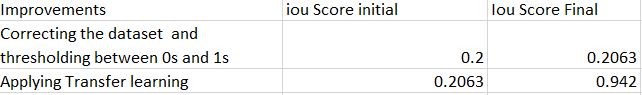

